In [1]:
import os
import argparse
import numpy as np
from glob import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import models
import dataloaders as dl
from utils import ideatlas, deeplearning
from tqdm.keras import TqdmCallback
import math

2025-05-06 17:13:38.689795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746551618.707025 1331128 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746551618.712885 1331128 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/bedru/anaconda3/envs/tf-geo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# List available GPUs
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPUs detected.")

In [3]:
import json
def load_config(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)
    return config
city = 'nairobi'
config = load_config('./config.json')
data_dir = config['data_dir'] + city + '/'
chk_dir = config['chkdir']

inputs = config["dataset"]
inputs_str = "_".join(inputs)

input_shapes = {input: config["in_shape"][input] for input in inputs}
for input, shape in input_shapes.items():
    # print(f"Shape of {input} is {shape}")
    dim = config["in_shape"][input]
    X,Y = dim[:2]

In [20]:
# model = models.mbcnn(CL=config["n_classes"], input_shapes=input_shapes, dropout_rate=0.2, batch_norm=True, drop_train=False)
# model = models.lightunet(input_shape = (X,Y,10), NUM_CLASSES=config["n_classes"])
model = models.fcndk3(input_shape=(X,Y,11), CL=config["n_classes"])
# weight = (f'./{chk_dir}/{city}.{inputs_str}.{model.name}.weights.h5')
weight = './checkpoint/nairobi.s2_pbd.fcndk3.weights.h5'
print(f'Model weight: {weight}')
model.load_weights(weight)

print(f'Model -> {model.name} \n'
        f'Parameters -> {model.count_params():,} \n')

Model weight: ./checkpoint/nairobi.s2_pbd.fcndk3.weights.h5
Model -> fcndk3 
Parameters -> 43,299 



In [21]:
#Test data
# test_s1 = ideatlas.load_image(data_dir + 'test', X, Y)
test_s2 = dl.load_image(data_dir + 'test', X, Y)
test_bd = dl.load_bd(data_dir + 'test', X, Y)
test_label = dl.load_mask(data_dir + 'test', X, Y, config['n_classes'])

test_s2 = dl.norm_s2(test_s2)
# test_images = [test_s2, test_bd]
test_images = np.concatenate((test_s2, test_bd), axis=-1)
print(f'Test data: {test_label.shape,  test_s2.shape,  test_bd.shape}')  

Test data: ((61, 128, 128, 3), (61, 128, 128, 10), (61, 128, 128, 1))


In [22]:
# print(f'Test data: {test_label.shape,  test_s1.shape, test_s2.shape,  test_bd.shape}')  
import metrics
class_report, cm = metrics.class_report(test_images, test_label, model)
print(f'Class report: {class_report}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Class report:               precision    recall  f1-score   support

        NBUA       0.87      0.86      0.87    629460
        NDUA       0.68      0.70      0.69    298477
         DUA       0.75      0.79      0.77     71487

    accuracy                           0.80    999424
   macro avg       0.77      0.78      0.77    999424
weighted avg       0.81      0.80      0.81    999424



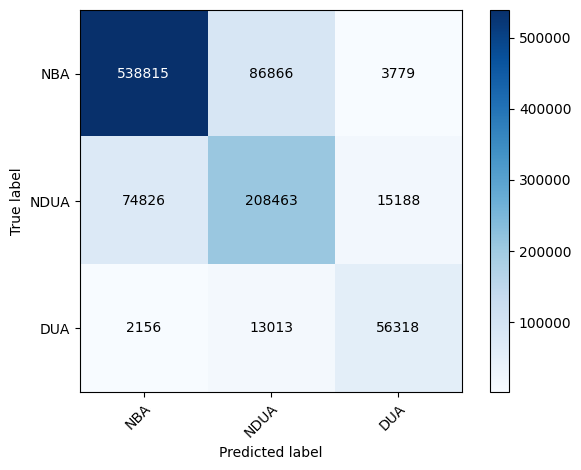

In [23]:
# # Plot the confusion matrix
ideatlas.plot_confusion_matrix(cm, save_plot=None)

Test image number: 59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0258..1.8108].


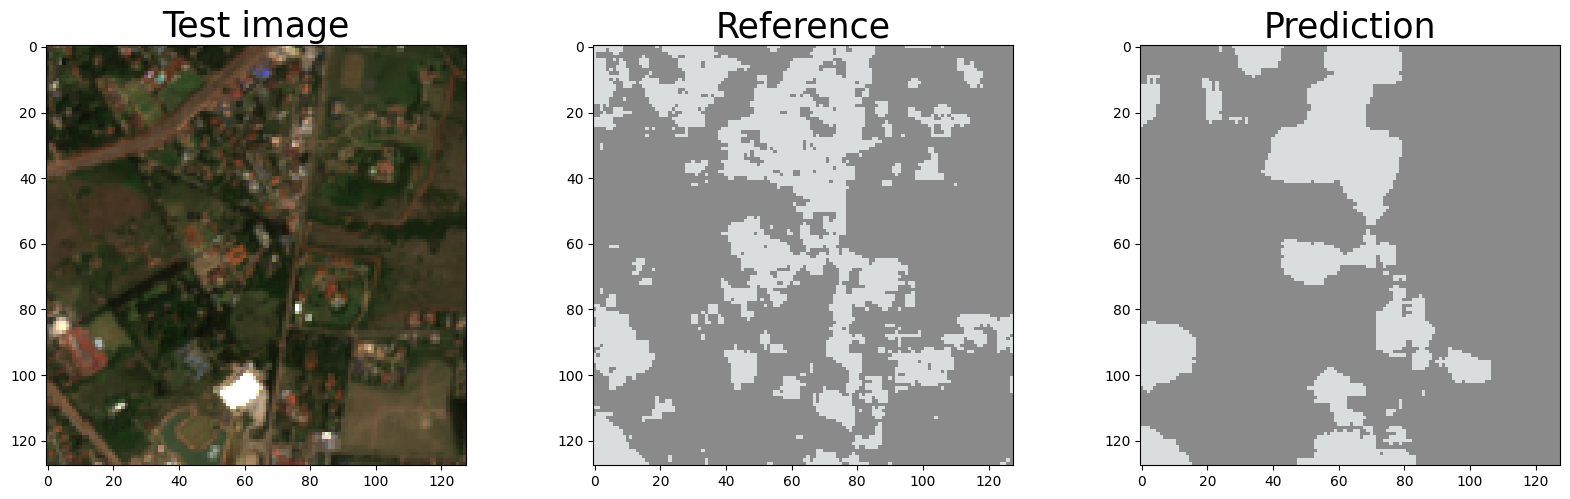

In [49]:
# plot_prediction_from_dataloader(test_images, test_label, model)
ideatlas.plot_prediction(test_images, test_label, model)
# ideatlas.plot_prediction_mbcnn(test_images, test_label, model)